Data source: https://www.kaggle.com/datasets/equilibriumm/sleep-efficiency/

# CRISP-DM
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

## 1. Business Understanding

Challenges & open questions
- Metadata on Kaggle is incomplete
- Is the data fake or real?
- Does each row in the dataset correspond to one individual or is it possible that the same individual appears more than once?

Assumptions
- There are 452 different individuals (however, that makes it impossible to correct for individual characteristics)
- Exercise frequency = number of exercise per week (answer found on kaggle)
- Alcohol consumption = number of drinks in the last 24h
- Caffeine consumption = caffeine [in mg] in the last 24h

Questions
1. Does age influence the sleep duration?
2. Does caffeine consumption decrease sleep efficiency?
3. What other factors are most important for sleep efficiency?



## 2. Data Understanding

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("sleep-efficiency-data/Sleep_Efficiency.csv")
df.columns = df.columns.str.replace(" ", "_")
print(f"{df.shape = }")
print(df.dtypes)
df.head()

df.shape = (452, 15)
ID                          int64
Age                         int64
Gender                     object
Bedtime                    object
Wakeup_time                object
Sleep_duration            float64
Sleep_efficiency          float64
REM_sleep_percentage        int64
Deep_sleep_percentage       int64
Light_sleep_percentage      int64
Awakenings                float64
Caffeine_consumption      float64
Alcohol_consumption       float64
Smoking_status             object
Exercise_frequency        float64
dtype: object


,ID,Age,Gender,Bedtime,Wakeup_time,Sleep_duration,Sleep_efficiency,REM_sleep_percentage,Deep_sleep_percentage,Light_sleep_percentage,Awakenings,Caffeine_consumption,Alcohol_consumption,Smoking_status,Exercise_frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


In [50]:
# df = df[df["Deep_sleep_percentage"] < 45.0]

### 15 columns of which
- 2 categorical
- 2 timestamps
- 11 numerical

In [51]:
cols_categorical = ["Gender", "Smoking_status"]
cols_datetime = ["Bedtime", "Wakeup_time"]
cols_numeric = [col for col in df.columns.tolist() if col not in cols_categorical + cols_datetime]

<AxesSubplot:xlabel='Gender,Smoking_status'>

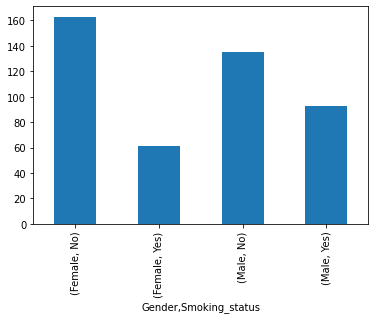

In [52]:
# Analyze categorical columns
x = df[cols_categorical].value_counts(sort=False)
x.plot(kind="bar")

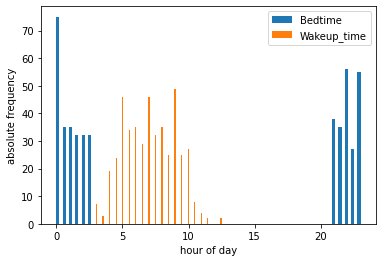

In [53]:
# Analyze datetime columns:
ax = plt.subplot()
for col in cols_datetime:
    col_as_dt = pd.to_datetime(df[col])
    hours = col_as_dt.dt.hour.values + col_as_dt.dt.minute.values / 60
    ax.hist(hours, bins=4 * 24, label=col)
    ax.set_xlabel("hour of day")
    ax.set_ylabel("absolute frequency")
    ax.legend()

In [54]:
# 11 numeric columns:
df[cols_numeric].describe()

,ID,Age,Sleep_duration,Sleep_efficiency,REM_sleep_percentage,Deep_sleep_percentage,Light_sleep_percentage,Awakenings,Caffeine_consumption,Alcohol_consumption,Exercise_frequency
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,432.000000,427.000000,438.000000,446.000000
mean,226.500000,40.285398,7.465708,0.788916,22.615044,52.823009,24.561947,1.641204,23.653396,1.173516,1.791480
std,130.625419,13.172250,0.866625,0.135237,3.525963,15.654235,15.313665,1.356762,30.202785,1.621377,1.428134
min,1.000000,9.000000,5.000000,0.500000,15.000000,18.000000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,113.750000,29.000000,7.000000,0.697500,20.000000,48.250000,15.000000,1.000000,0.000000,0.000000,0.000000
50%,226.500000,40.000000,7.500000,0.820000,22.000000,58.000000,18.000000,1.000000,25.000000,0.000000,2.000000
75%,339.250000,52.000000,8.000000,0.900000,25.000000,63.000000,32.500000,3.000000,50.000000,2.000000,3.000000
max,452.000000,69.000000,10.000000,0.990000,30.000000,75.000000,63.000000,4.000000,200.000000,5.000000,5.000000


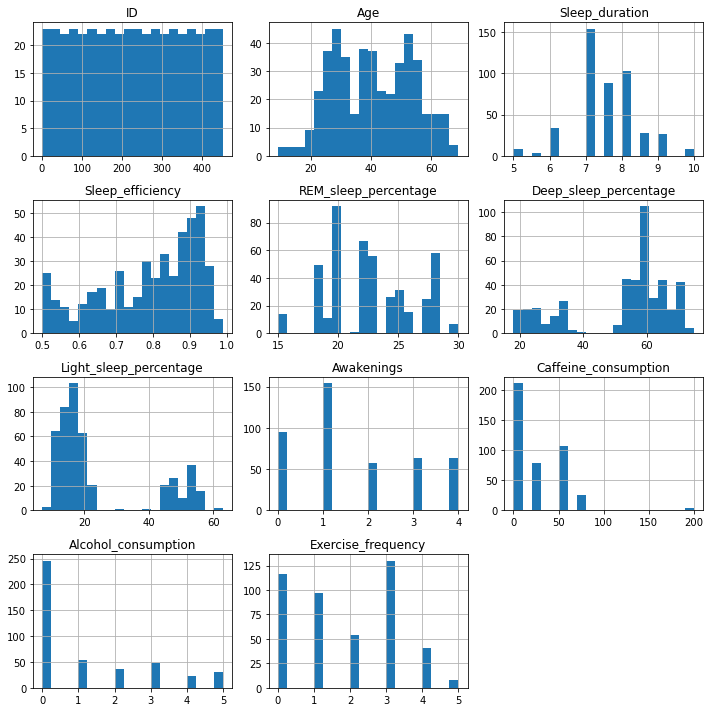

In [55]:
df[cols_numeric].hist(bins=20, figsize=(10, 10))
plt.tight_layout()

### Observations:
- Data looks rather clean and plausible
- No obvious outliers
- ID irrelevant
- Two interesting clusters regarding deep & light sleep
- Bedtime (from 21:00 to 2:30) and Wakeup_time (from 3:00 to 12:30) 
    - only time is interesting (date does not matter)
    - need special handling 

## 3. Data Preparation

In [56]:
df_clean = df.copy(deep=True)

### Handle categorical columns:

In [57]:
# It seems to be fine to create dummy variables because we have at least 61 samples per combination
cat_dummies = pd.get_dummies(data=df_clean[cols_categorical], dtype=float)
df_clean = df_clean.drop(columns=cols_categorical)
df_clean = pd.concat([df_clean, cat_dummies], axis="columns")

In [58]:
df_clean.head()

,ID,Age,Bedtime,Wakeup_time,Sleep_duration,Sleep_efficiency,REM_sleep_percentage,Deep_sleep_percentage,Light_sleep_percentage,Awakenings,Caffeine_consumption,Alcohol_consumption,Exercise_frequency,Gender_Female,Gender_Male,Smoking_status_No,Smoking_status_Yes
0,1,65,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0
1,2,69,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,3.0,0.0,1.0,0.0,1.0
2,3,40,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0
3,4,40,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,1.0,1.0,0.0,0.0,1.0
4,5,57,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0


### Handle timestamp columns:

In [59]:
def convert_timestamp_to_hours_after_midnight(timestamp):
    """
    Convert a pandas Timestamp to its equivalent hours after midnight.
    Times between 00:00 and 18:00 (morning + daytime) are represented by positive values from 0.0 to 18
    Times between 18:00 and 00:00 (evening) are represented by negative values from -6.0 to 0.0

    Examples:
        timestamp = Timestamp('2021-03-06 01:00:00') --> hours_after_midnight = 1.0
        timestamp = Timestamp('2022-01-03 21:30:00') --> hours_after_midnight = -2.5

    Parameters
    ----------
    timestamp: pd.Timestamp
        given timestamp


    Returns
    -------
    float:
        representation of given timestamp in hours after/before midnight

    """
    hours_after_midnight = timestamp.hour + timestamp.minute / 60
    if hours_after_midnight > 18:
        hours_after_midnight -= 24
    return hours_after_midnight

In [60]:
for col in cols_datetime:
    df_clean[col] = pd.to_datetime(df_clean[col])
    df_clean[col] = df_clean[col].apply(convert_timestamp_to_hours_after_midnight)

In [61]:
df_clean.head()

,ID,Age,Bedtime,Wakeup_time,Sleep_duration,Sleep_efficiency,REM_sleep_percentage,Deep_sleep_percentage,Light_sleep_percentage,Awakenings,Caffeine_consumption,Alcohol_consumption,Exercise_frequency,Gender_Female,Gender_Male,Smoking_status_No,Smoking_status_Yes
0,1,65,1.0,7.0,6.0,0.88,18,70,12,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0
1,2,69,2.0,9.0,7.0,0.66,19,28,53,3.0,0.0,3.0,3.0,0.0,1.0,0.0,1.0
2,3,40,-2.5,5.5,8.0,0.89,20,70,10,1.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0
3,4,40,2.5,8.5,6.0,0.51,23,25,52,3.0,50.0,5.0,1.0,1.0,0.0,0.0,1.0
4,5,57,1.0,9.0,8.0,0.76,27,55,18,3.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0


In [62]:
assert all(df_clean["Wakeup_time"] - df_clean["Bedtime"] - df_clean["Sleep_duration"] == 0)

In [63]:
# Now, all columns are numeric:
df_clean.describe()

,ID,Age,Bedtime,Wakeup_time,Sleep_duration,Sleep_efficiency,REM_sleep_percentage,Deep_sleep_percentage,Light_sleep_percentage,Awakenings,Caffeine_consumption,Alcohol_consumption,Exercise_frequency,Gender_Female,Gender_Male,Smoking_status_No,Smoking_status_Yes
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,432.000000,427.000000,438.000000,446.000000,452.000000,452.000000,452.000000,452.000000
mean,226.500000,40.285398,-0.363938,7.101770,7.465708,0.788916,22.615044,52.823009,24.561947,1.641204,23.653396,1.173516,1.791480,0.495575,0.504425,0.659292,0.340708
std,130.625419,13.172250,1.687559,1.955899,0.866625,0.135237,3.525963,15.654235,15.313665,1.356762,30.202785,1.621377,1.428134,0.500534,0.500534,0.474472,0.474472
min,1.000000,9.000000,-3.000000,3.000000,5.000000,0.500000,15.000000,18.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,113.750000,29.000000,-2.000000,5.500000,7.000000,0.697500,20.000000,48.250000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,226.500000,40.000000,0.000000,7.000000,7.500000,0.820000,22.000000,58.000000,18.000000,1.000000,25.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000
75%,339.250000,52.000000,1.000000,9.000000,8.000000,0.900000,25.000000,63.000000,32.500000,3.000000,50.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000
max,452.000000,69.000000,2.500000,12.500000,10.000000,0.990000,30.000000,75.000000,63.000000,4.000000,200.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
# Drop irrelevant columns
df_clean = df_clean.drop(columns=["ID", "Gender_Male", "Smoking_status_No"])

### Handle missing values
- We only have missing values in 4 columns: 
    - Awakenings
    - Caffeine_consumption
    - Alcohol_consumption
    - Exercise_frequency
- Dropping all correspondent rows would lead to 14% less data (see calculation below), which I would not want to do because we already have few data available
- Dropping the entire columns is also not an option because caffeine / alcohol / exercise will be important predictors 
- That is why I decided to replace the missing values with the column mean
- I know this diludes the dataset to some extent, but I think that is ok, given that it will effect at most 452-427=25 values per column

In [65]:
# Potential effect of dropping all rows containing NAN values:
rows_before = len(df_clean)
rows_after_dropping_all_nans =  len(df_clean.dropna())
print(rows_before)
print(rows_after_dropping_all_nans)
print(1-rows_after_dropping_all_nans/rows_before)

452
388
0.1415929203539823


In [66]:
# Handle missing values: replace by column mean
print(len(df_clean))
cols_including_nan = df_clean.columns[df_clean.isna().any(axis=0)]
df_clean[cols_including_nan] = df_clean[cols_including_nan].fillna(value=df_clean[cols_including_nan].mean(axis=0))
print(len(df_clean))

452
452


Very high correlation


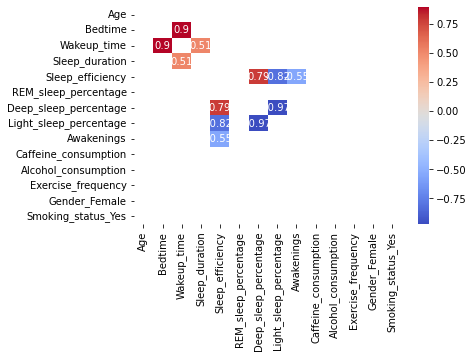

High correlation


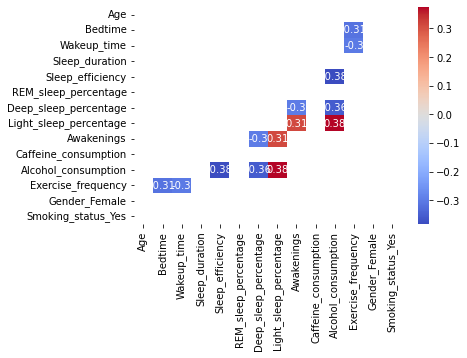

Medium correlation


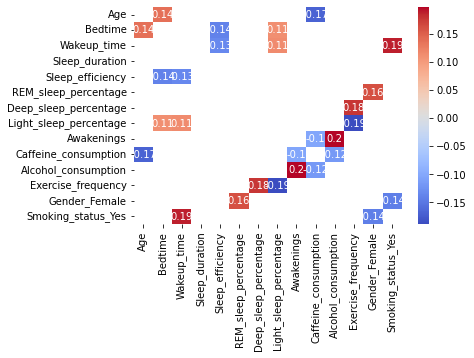

In [67]:
corr_limits = {
    "Very high correlation": {"low": 0.5, "high": 1.0},
    "High correlation": {"low": 0.3, "high": 0.5},
    "Medium correlation": {"low": 0.1, "high": 0.2},
}
for corr_name, corr_limit in corr_limits.items():
    print(corr_name)
    mask1 = df_clean.corr().abs() > corr_limit["low"]
    mask2 = df_clean.corr().abs() < corr_limit["high"]
    corr = df_clean.corr()[mask1 & mask2]
    plt.figure()
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.show()

### Analyze correlation plot:
- light sleep and deep sleep seem to be almost perfectly negatively correlated
- sleep efficiency is strongly correlated with deep sleep
- sleep duration depends more on wakeup_time than on bedtime
- people who do more exercise, go to bed earlier
- alcohol decreases deep sleep and sleep efficiency

Take away: When trying to predict sleep efficiency one should not take deep and light sleep into the equation

## 4. Modeling

In [68]:
df_clean.head()

,Age,Bedtime,Wakeup_time,Sleep_duration,Sleep_efficiency,REM_sleep_percentage,Deep_sleep_percentage,Light_sleep_percentage,Awakenings,Caffeine_consumption,Alcohol_consumption,Exercise_frequency,Gender_Female,Smoking_status_Yes
0,65,1.0,7.0,6.0,0.88,18,70,12,0.0,0.0,0.0,3.0,1.0,1.0
1,69,2.0,9.0,7.0,0.66,19,28,53,3.0,0.0,3.0,3.0,0.0,1.0
2,40,-2.5,5.5,8.0,0.89,20,70,10,1.0,0.0,0.0,3.0,1.0,0.0
3,40,2.5,8.5,6.0,0.51,23,25,52,3.0,50.0,5.0,1.0,1.0,1.0
4,57,1.0,9.0,8.0,0.76,27,55,18,3.0,0.0,3.0,3.0,0.0,0.0


[[ 1.         -0.06246207]
 [-0.06246207  1.        ]]


Text(0, 0.5, 'Sleep_duration')

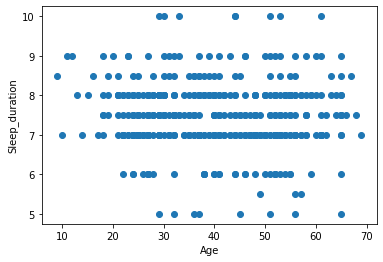

In [69]:
age = df_clean["Age"]
sleep_duration = df_clean["Sleep_duration"]
print(np.corrcoef(age, sleep_duration))
plt.scatter(age, sleep_duration)
plt.xlabel("Age")
plt.ylabel("Sleep_duration")

In [70]:
X = df_clean[[
    "Age",
    "Gender_Female",
    "Smoking_status_Yes",
    "Caffeine_consumption",
    "Alcohol_consumption",
    "Exercise_frequency",
    "Bedtime",
    "Sleep_duration",
]]
y = df_clean["Sleep_efficiency"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("Without normalization")
reg = LinearRegression().fit(X_train, y_train)
print(f"{reg.score(X_train, y_train) = }")
print(f"{reg.score(X_test, y_test) = }")

print("MinMax normalization")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X=X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)
reg_scaled = LinearRegression().fit(X_train_scaled, y_train)
print(f"{reg_scaled.score(X_train_scaled, y_train) = }")
print(f"{reg_scaled.score(X_test_scaled, y_test) = }")

Without normalization
reg.score(X_train, y_train) = 0.26422759115987293
reg.score(X_test, y_test) = 0.3309830147501094
MinMax normalization
reg_scaled.score(X_train_scaled, y_train) = 0.26422759115987293
reg_scaled.score(X_test_scaled, y_test) = 0.3309830147501094


Analysis of normalized features:


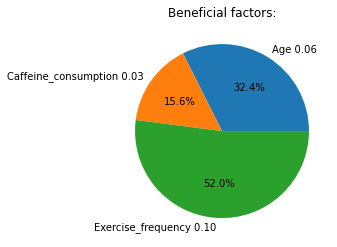

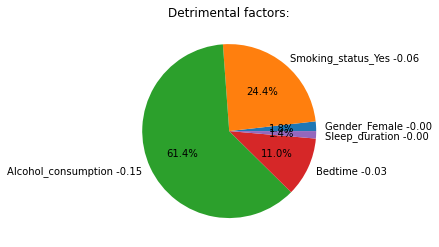

In [71]:
print("Analysis of normalized features:")
labels = np.array([f"{a} {b:.2f}" for a, b in zip(X.columns, reg_scaled.coef_)])
plt.pie(x=reg_scaled.coef_[reg_scaled.coef_ > 0],
        labels=labels[reg_scaled.coef_ > 0],
        autopct='%1.1f%%')
plt.title(f"Beneficial factors:")
plt.show()
plt.pie(x=np.abs(reg_scaled.coef_[reg_scaled.coef_ < 0]),
        labels=labels[reg_scaled.coef_ < 0],
        autopct='%1.1f%%')
plt.title(f"Detrimental factors:")
plt.show()

In [72]:
print("Analysis of non-normalized factors:")
for label, coef in zip(X.columns, reg.coef_):
    print(f"{label} --> {coef:.2%}")

Analysis of non-normalized factors:
Age --> 0.10%
Gender_Female --> -0.44%
Smoking_status_Yes --> -5.96%
Caffeine_consumption --> 0.01%
Alcohol_consumption --> -3.00%
Exercise_frequency --> 1.90%
Bedtime --> -0.49%
Sleep_duration --> -0.07%


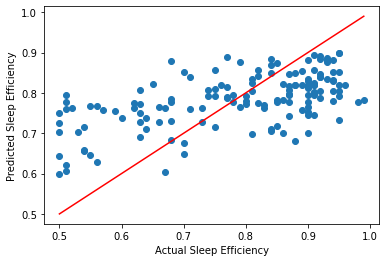

In [73]:
y_pred = reg.predict(X_test)
plt.scatter(y_test.values, y_pred)
plt.plot(y_test.sort_values().values, y_test.sort_values().values, color="r")
plt.xlabel("Actual Sleep Efficiency")
plt.ylabel("Predicted Sleep Efficiency")
plt.show()

## 5. Evaluation

Answers to Business Questions from 1:
1. Age does not seem to influence sleep duration
2. Unexpectedly, caffeine consumption had a positive effect on sleep efficiency
3. Most important beneficial factor is exercise frequency and most important detrimental factor is alcohol consumption

Other observations / remarks
- Results are to be taken with a grain of salt
- r2 score is very low and most of the variance remains unexplained
- No explanation for the two clusters in deep sleep: 
- It is unclear if the whole dataset is fake (even though it's stated that it comes from a study)
- Careful with strongly correlated variables

## 6. Deployment

In this case, deployment means we provide some advice: 
- Never trust data you haven't collected yourself
- Perform a longitudinal study with the same individuals
- Collect data in a finer way (e.g., sleep duration on a minute basis)
- Do more exercise and drink less (always a good recommendation ;-))